# PhaseNet Example

Applying GaMMA to associate PhaseNet picks

In [1]:
!pip install git+https://github.com/wayneweiqiang/GaMMA.git

  Cloning https://github.com/wayneweiqiang/GaMMA.git to /tmp/pip-req-build-qtht7yi3
  Running command git clone --filter=blob:none --quiet https://github.com/wayneweiqiang/GaMMA.git /tmp/pip-req-build-qtht7yi3
  Resolved https://github.com/wayneweiqiang/GaMMA.git to commit 7fcfd694ba30d9adea15705538b8b303e390072f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for GMMA: filename=GMMA-1.2.6-py3-none-any.whl size=32457 sha256=34dcd8801262927f74963bc1a619b2ef38ce86e07245c3bfb6961d5d63cd2557
  Stored in directory: /tmp/pip-ephem-wheel-cache-bqgqt4rg/wheels/14/8e/61/5bbc1e42d9555c7fd6da162fecc9b834fe1564875e1c845d4b
Successfully built GMMA
  Attempting uninstall: GMMA
    Found existing installation: GMMA 1.2.6
    Uninstalling GMMA-1.2.6:
      Successfully uninstalled GMMA-1.2.6


In [2]:
import pandas as pd
from gamma.utils import association, estimate_eps
import numpy as np
import os
from pyproj import Proj


## 1. Download demo data

There are two examples in the demo data: Ridgecrest, CA and Chile.

**Phase Picks**:
- test_data/ridgecrest
    - picks.csv
    - stations.csv
    - standard_catalog.csv
- test_data/chile
    - picks.csv
    - stations.csv
    - iasp91.csv

**Results**:
- test_data/ridgecrest
    - gamma_events.csv
    - gamma_picks.csv
- test_data/chile
    - gamma_events.csv
    - gamma_picks.csv

In [3]:
!if [ -f demo.tar ]; then rm demo.tar; fi
!if [ -d test_data ]; then rm -rf test_data; fi
!wget -q https://github.com/AI4EPS/GaMMA/releases/download/test_data/demo.tar
!tar -xf demo.tar

In [4]:
region = "ridgecrest"
# region = "chile"
data_path = lambda x: os.path.join(f"test_data/{region}", x)
result_path = f"results/{region}"
if not os.path.exists(result_path):
    os.makedirs(result_path)
result_path = lambda x: os.path.join(f"results/{region}", x)
station_csv = data_path("stations.csv")
picks_csv = data_path("picks.csv")
if not os.path.exists("figures"):
    os.makedirs("figures")
figure_dir = lambda x: os.path.join("figures", x)

In [5]:
## read picks
picks = pd.read_csv(picks_csv, parse_dates=["phase_time"])
picks.rename(columns={"station_id": "id", "phase_time": "timestamp", "phase_type": "type", "phase_score": "prob", "phase_amplitude": "amp"}, inplace=True)
print("Pick format:", picks.iloc[:10])

## read stations
stations = pd.read_csv(station_csv)
stations.rename(columns={"station_id": "id"}, inplace=True)
print("Station format:", stations.iloc[:10])

## Automatic region; you can also specify a region
x0 = stations["longitude"].median()
y0 = stations["latitude"].median()
xmin = stations["longitude"].min()
xmax = stations["longitude"].max()
ymin = stations["latitude"].min()
ymax = stations["latitude"].max()
config = {}
config["center"] = (x0, y0)
config["xlim_degree"] = (2 * xmin - x0, 2 * xmax - x0)
config["ylim_degree"] = (2 * ymin - y0, 2 * ymax - y0)

## projection to km
proj = Proj(f"+proj=sterea +lon_0={config['center'][0]} +lat_0={config['center'][1]} +units=km")
stations[["x(km)", "y(km)"]] = stations.apply(lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1)
stations["z(km)"] = stations["elevation_m"].apply(lambda x: -x/1e3)

### setting GMMA configs
config["use_dbscan"] = True
if region == "chile":
    config["use_amplitude"] = False
else:
    config["use_amplitude"] = True
config["method"] = "BGMM"  
if config["method"] == "BGMM": ## BayesianGaussianMixture
    config["oversample_factor"] = 5
if config["method"] == "GMM": ## GaussianMixture
    config["oversample_factor"] = 1

# earthquake location
config["vel"] = {"p": 6.0, "s": 6.0 / 1.75}
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["x(km)"] = proj(longitude=config["xlim_degree"], latitude=[config["center"][1]] * 2)[0]
config["y(km)"] = proj(longitude=[config["center"][0]] * 2, latitude=config["ylim_degree"])[1]
if region == "ridgecrest":
    config["z(km)"] = (0, 20)
elif region == "chile":
    config["z(km)"] = (0, 250)
else:
    print("Please specify z(km) for your region")
    raise NotImplementedError
config["bfgs_bounds"] = (
    (config["x(km)"][0] - 1, config["x(km)"][1] + 1),  # x
    (config["y(km)"][0] - 1, config["y(km)"][1] + 1),  # y
    (0, config["z(km)"][1] + 1),  # z
    (None, None),  # t
)

# DBSCAN
config["dbscan_eps"] = estimate_eps(stations, config["vel"]["p"])
config["dbscan_min_samples"] = 3

## using Eikonal for 1D velocity model
if region == "ridgecrest":
    zz = [0.0, 5.5, 16.0, 32.0]
    vp = [5.5, 5.5,  6.7,  7.8]
    vp_vs_ratio = 1.73
    vs = [v / vp_vs_ratio for v in vp]
    h = 1.0
    vel = {"z": zz, "p": vp, "s": vs}
    config["eikonal"] = {"vel": vel, "h": h, "xlim": config["x(km)"], "ylim": config["y(km)"], "zlim": config["z(km)"]}
elif region == "chile":
    velocity_model = pd.read_csv(data_path("iasp91.csv"), names=["zz", "rho", "vp", "vs"])
    velocity_model = velocity_model[velocity_model["zz"] <= config["z(km)"][1]]
    vel = {"z": velocity_model["zz"].values, "p": velocity_model["vp"].values, "s": velocity_model["vs"].values}
    h = 1.0
    config["eikonal"] = {"vel": vel, "h": h, "xlim": config["x(km)"], "ylim": config["y(km)"], "zlim": config["z(km)"]}
else:
    print("Using uniform velocity model")

if region == "chile":
    config["initial_points"] = [1, 1, 1] # x, y, z

# set number of cpus
config["ncpu"] = 32

# filtering
config["min_picks_per_eq"] = 5
config["min_p_picks_per_eq"] = 0
config["min_s_picks_per_eq"] = 0
config["max_sigma11"] = 3.0 # second
config["max_sigma22"] = 1.0 # log10(m/s)
config["max_sigma12"] = 1.0 # covariance

## filter picks without amplitude measurements
if config["use_amplitude"]:
    picks = picks[picks["amp"] != -1]

for k, v in config.items():
    print(f"{k}: {v}")


Pick format:            id               timestamp      prob       amp type
0  CI.CCC..BH 2019-07-04 22:00:06.084  0.939738  0.000017    P
1  CI.CCC..BH 2019-07-04 22:00:31.934  0.953992  0.000006    P
2  CI.CCC..BH 2019-07-04 22:00:38.834  0.837302  0.000006    P
3  CI.CCC..BH 2019-07-04 22:01:15.654  0.881130  0.000005    P
4  CI.CCC..BH 2019-07-04 22:01:32.054  0.869447  0.000004    P
5  CI.CCC..BH 2019-07-04 22:01:45.574  0.921890  0.000007    P
6  CI.CCC..BH 2019-07-04 22:02:39.534  0.973068  0.000860    P
7  CI.CCC..BH 2019-07-04 22:03:36.054  0.972033  0.000030    P
8  CI.CCC..BH 2019-07-04 22:03:44.014  0.532193  0.000038    P
9  CI.CCC..BH 2019-07-04 22:04:13.174  0.953794  0.000026    P
Station format:             id  longitude  latitude  elevation_m
0   CI.CCC..BH   -117.365    35.525        670.0
1   CI.CCC..HH   -117.365    35.525        670.0
2   CI.CCC..HN   -117.365    35.525        670.0
3   CI.CLC..BH   -117.598    35.816        775.0
4   CI.CLC..HH   -117.598    35.8

## 2. Associaiton with GaMMA

In [6]:
event_idx0 = 0 ## current earthquake index
assignments = []
events, assignments = association(picks, stations, config, event_idx0, config["method"])
event_idx0 += len(events)

## create catalog
events = pd.DataFrame(events)
events[["longitude","latitude"]] = events.apply(lambda x: pd.Series(proj(longitude=x["x(km)"], latitude=x["y(km)"], inverse=True)), axis=1)
events["depth_km"] = events["z(km)"]
events.to_csv(result_path("gamma_events.csv"), index=False, 
                float_format="%.3f",
                date_format='%Y-%m-%dT%H:%M:%S.%f')

## add assignment to picks
assignments = pd.DataFrame(assignments, columns=["pick_index", "event_index", "gamma_score"])
picks = picks.join(assignments.set_index("pick_index")).fillna(-1).astype({'event_index': int})
picks.rename(columns={"id": "station_id", "timestamp": "phase_time", "type": "phase_type", "prob": "phase_score", "amp": "phase_amplitude"}, inplace=True)
picks.to_csv(result_path("gamma_picks.csv"), index=False, 
                date_format='%Y-%m-%dT%H:%M:%S.%f')

Eikonal Solver: 
Iter 0, error = 999.818
Iter 1, error = 0.000
Time: 3.676
Eikonal Solver: 
Iter 0, error = 999.685
Iter 1, error = 0.000
Time: 0.005
Associating 662 clusters with 4 CPUs
................................................
Associated 100 events.
....................................................
Associated 200 events
...................................
Associated 300 events
....
Initialization 1 did not converge.
............................
Associated 400 events
.......................................
Associated 500 events
...................
Associated 600 events
...........................................
Initialization 1 did not converge.
..
Associated 700 events
...........................................
Associated 800 events
..................................
Associated 900 events
.......................................
Associated 1000 events
......................................
Associated 1100 events
................................
Associated 1200 events
.....

## 3. Filtering based on Nearest Station Ratio (Not required)

In [7]:
# %%
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd

events = pd.read_csv(result_path("gamma_events.csv"))
picks = pd.read_csv(result_path("gamma_picks.csv"))
stations = pd.read_csv(data_path("stations.csv"))

MIN_NEAREST_STATION_RATIO = 0.3

# %%
stations = stations[stations["station_id"].isin(picks["station_id"].unique())]

neigh = NearestNeighbors(n_neighbors=min(len(stations), 10))
neigh.fit(stations[["longitude", "latitude"]].values)

# %%
picks = picks.merge(events[["event_index", "longitude", "latitude"]], on="event_index", suffixes=("", "_event"))
picks = picks.merge(stations[["station_id", "longitude", "latitude"]], on="station_id", suffixes=("", "_station"))

# %%
filtered_events = []
for i, event in tqdm(events.iterrows(), total=len(events)):
    # sid = neigh.kneighbors([[event["longitude"], event["latitude"]]])[1][0]
    picks_ = picks[picks["event_index"] == event["event_index"]]
    longitude, latitude = picks_[["longitude", "latitude"]].mean().values
    sid = neigh.kneighbors([[longitude, latitude]])[1][0]
    stations_neigh = stations.iloc[sid]["station_id"].values
    picks_neigh = picks_[picks_["station_id"].isin(stations_neigh)]
    stations_with_picks = picks_neigh["station_id"].unique()
    if len(stations_with_picks) / len(stations_neigh) > MIN_NEAREST_STATION_RATIO:
        filtered_events.append(event)

# %%
print(f"Events before filtering: {len(events)}")
print(f"Events after filtering: {len(filtered_events)}")
filtered_events = pd.DataFrame(filtered_events)
os.system(f"mv {result_path('gamma_events.csv')} {result_path('gamma_events_raw.csv')}")
filtered_events.to_csv(result_path("gamma_events.csv"), index=False)


100%|██████████| 1895/1895 [00:03<00:00, 583.17it/s]

Events before filtering: 1895
Events after filtering: 1379


## 4. Visualize results

Note that the location and magnitude are estimated during associaiton, which are not expected to have high accuracy. 

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
result_label="GaMMA"
catalog_label="Standard"

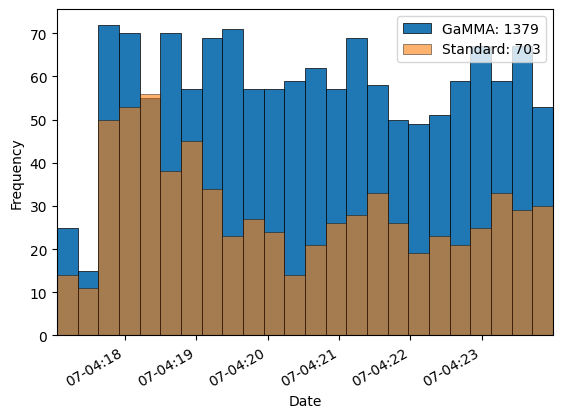

In [9]:
stations = pd.read_csv(data_path("stations.csv"))
gamma_events = pd.read_csv(result_path("gamma_events.csv"), parse_dates=["time"])

if os.path.exists(data_path("standard_catalog.csv")):
    standard_catalog = pd.read_csv(data_path("standard_catalog.csv"), parse_dates=["time"])
    starttime = standard_catalog["time"].min()
    endtime = standard_catalog["time"].max()
else:
    standard_catalog = None
    starttime = gamma_events["time"].min()
    endtime = gamma_events["time"].max()


plt.figure()
plt.hist(gamma_events["time"], range=(starttime, endtime), bins=24, edgecolor="k", alpha=1.0, linewidth=0.5, label=f"{result_label}: {len(gamma_events['time'])}")
if standard_catalog is not None:
    plt.hist(standard_catalog["time"], range=(starttime, endtime), bins=24, edgecolor="k", alpha=0.6, linewidth=0.5, label=f"{catalog_label}: {len(standard_catalog['time'])}")
plt.ylabel("Frequency")
plt.xlabel("Date")
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig(figure_dir("earthquake_number.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("earthquake_number.pdf"), bbox_inches="tight")
plt.show();

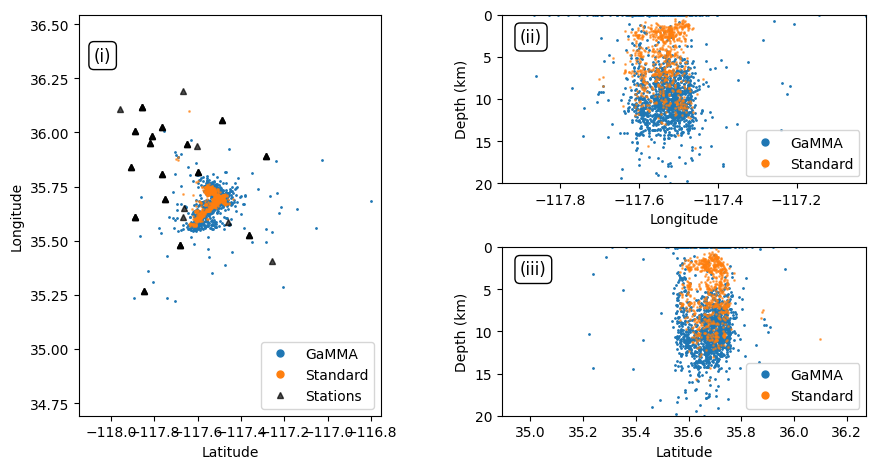

In [10]:
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([1.5,1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.92]
grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5, 1], height_ratios=[1,1])
fig.add_subplot(grd[:, 0])
plt.plot(gamma_events["longitude"], gamma_events["latitude"], '.',markersize=2, alpha=1.0)
if standard_catalog is not None:
    plt.plot(standard_catalog["longitude"], standard_catalog["latitude"], '.', markersize=2, alpha=0.6)
plt.axis("scaled")
plt.xlim(np.array(config["xlim_degree"]))
plt.ylim(np.array(config["ylim_degree"]))
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.gca().set_prop_cycle(None)
plt.plot([], [], '.', markersize=10, label=f"{result_label}", rasterized=True)
plt.plot([], [], '.', markersize=10, label=f"{catalog_label}", rasterized=True)
plt.plot(stations["longitude"], stations["latitude"], 'k^', markersize=5, alpha=0.7, label="Stations")
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[0, 1])
plt.plot(gamma_events["longitude"], gamma_events["depth_km"], '.', markersize=2, alpha=1.0, rasterized=True)
if standard_catalog is not None:
    plt.plot(standard_catalog["longitude"], standard_catalog["depth_km"], '.', markersize=2, alpha=0.6, rasterized=True)
plt.xlim(np.array(config["xlim_degree"])+np.array([0.2,-0.27]))
plt.ylim(config["z(km)"])
plt.gca().invert_yaxis()
plt.xlabel("Longitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot([], [], '.', markersize=10, label=f"{result_label}")
plt.plot([], [], '.', markersize=10, label=f"{catalog_label}")
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[1, 1])
plt.plot(gamma_events["latitude"], gamma_events["depth_km"], '.', markersize=2, alpha=1.0, rasterized=True)
if standard_catalog is not None:
    plt.plot(standard_catalog["latitude"], standard_catalog["depth_km"], '.', markersize=2, alpha=0.6, rasterized=True)
plt.xlim(np.array(config["ylim_degree"])+np.array([0.2,-0.27]))
plt.ylim(config["z(km)"])
plt.gca().invert_yaxis()
plt.xlabel("Latitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot([], [], '.', markersize=10, label=f"{result_label}")
plt.plot([], [], '.', markersize=10, label=f"{catalog_label}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.savefig(figure_dir("earthquake_location.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("earthquake_location.pdf"), bbox_inches="tight", dpi=300)
plt.show();

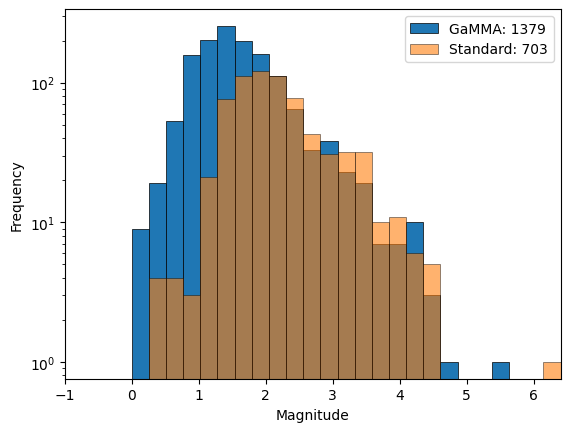

In [11]:
if standard_catalog is not None:
    range = (0, standard_catalog["magnitude"].max())
else:
    range = (-1, gamma_events["magnitude"].max())
if (gamma_events["magnitude"] != 999).any():
    plt.figure()
    plt.hist(gamma_events["magnitude"], range=range, bins=25, alpha=1.0,  edgecolor="k", linewidth=0.5, label=f"{result_label}: {len(gamma_events['magnitude'])}")
    if standard_catalog is not None:
        plt.hist(standard_catalog["magnitude"], range=range, bins=25, alpha=0.6,  edgecolor="k", linewidth=0.5, label=f"{catalog_label}: {len(standard_catalog['magnitude'])}")
    plt.legend()
    plt.xlim([-1,standard_catalog["magnitude"].max()])
    plt.xlabel("Magnitude")
    plt.ylabel("Frequency")
    plt.gca().set_yscale('log')
    plt.savefig(figure_dir("earthquake_magnitude_frequency.png"), bbox_inches="tight", dpi=300)
    plt.savefig(figure_dir("earthquake_magnitude_frequency.pdf"), bbox_inches="tight")
    plt.show();

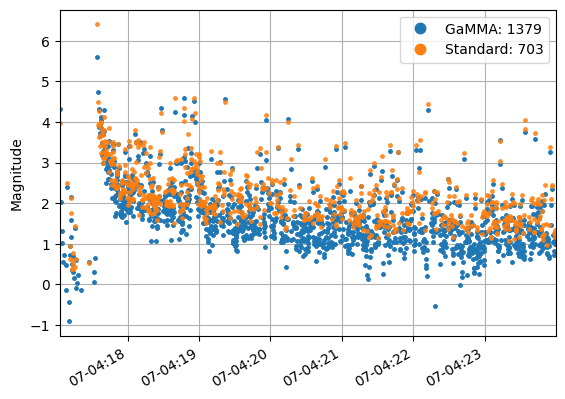

In [12]:
if (gamma_events["magnitude"] != 999).any():
    plt.figure()
    plt.plot(gamma_events["time"], gamma_events["magnitude"], '.', markersize=5, alpha=1.0, rasterized=True)
    if standard_catalog is not None:
        plt.plot(standard_catalog["time"], standard_catalog["magnitude"], '.', markersize=5, alpha=0.8, rasterized=True)
    plt.xlim([starttime, endtime])
    ylim = plt.ylim()
    plt.ylabel("Magnitude")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
    plt.gcf().autofmt_xdate()
    plt.gca().set_prop_cycle(None)
    plt.plot([],[], '.', markersize=15, alpha=1.0, label=f"{result_label}: {len(gamma_events['magnitude'])}")
    plt.plot([],[], '.', markersize=15, alpha=1.0, label=f"{catalog_label}: {len(standard_catalog['magnitude'])}")
    plt.legend()
    plt.ylim(ylim)
    plt.grid()
    plt.savefig(figure_dir("earthquake_magnitude_time.png"), bbox_inches="tight", dpi=300)
    plt.savefig(figure_dir("earthquake_magnitude_time.pdf"), bbox_inches="tight", dpi=300)
    plt.show();

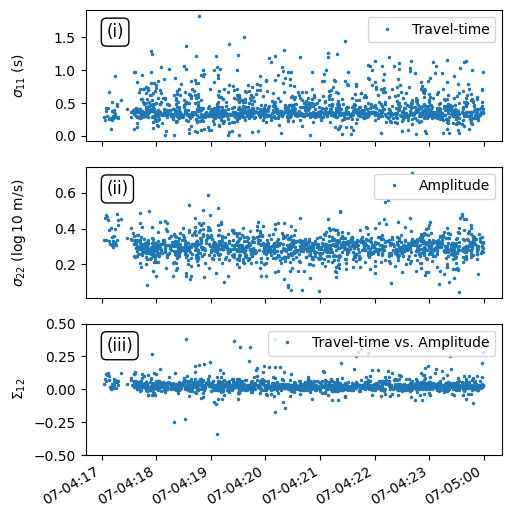

In [13]:
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([0.8,1.1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.90]
plt.subplot(311)
plt.plot(gamma_events["time"], gamma_events["sigma_time"], '.', markersize=3.0, label="Travel-time")
plt.ylabel(r"$\sigma_{11}$ (s)")
plt.legend(loc="upper right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.subplot(312)
plt.plot(gamma_events["time"], gamma_events["sigma_amp"], '.', markersize=3.0, label="Amplitude")
plt.ylabel(r"$\sigma_{22}$ ($\log10$ m/s)")
plt.legend(loc="upper right")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.subplot(313)
plt.plot(gamma_events["time"], gamma_events["cov_time_amp"], '.', markersize=3.0, label="Travel-time vs. Amplitude")
plt.ylabel(r"$\Sigma_{12}$")
plt.ylim([-0.5, 0.5])
plt.legend(loc="upper right")
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.gcf().align_labels()
plt.savefig(figure_dir("covariance.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("covariance.pdf"), bbox_inches="tight")
plt.show();